In [1]:
import datetime as dt
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj
#from google.colab import files

In [2]:
def get_goes_dataset(year, month, day, hour, product="ABI-L2-CMIPF", sat="goes-east", band="12"):
    date = dt.datetime(year, month, day)
    jday = date.timetuple().tm_yday

    syr = str(year).zfill(4)
    sjd = str(jday).zfill(3)
    shr = str(hour).zfill(2)

    fs = s3fs.S3FileSystem(anon=True)

    if sat == "goes-east":
      files = fs.glob(f"s3://noaa-goes16/{product}/{syr}/{sjd}/{shr}/*C{band}*.nc")
    else:
      files = fs.glob(f"s3://noaa-goes17/{product}/{syr}/{sjd}/{shr}/*C{band}*.nc")

    if len(files) == 0:
        raise ValueError("No GOES files found. Check date/hour/band.")

    print(f"Found {len(files)} files for {year}-{month}-{day} {hour}Z, Band {band}")

    file_objs = [fs.open(f) for f in files]
    ds = xr.open_mfdataset(file_objs, combine="nested", concat_dim="time")

    ds = ds.rename({"t": "time"}).reset_coords()

    return ds

In [3]:
def add_lat_lon(ds):
    p = ds.goes_imager_projection
    h = p.perspective_point_height + p.semi_major_axis
    lon_0 = p.longitude_of_projection_origin
    sweep = p.sweep_angle_axis
    a = p.semi_major_axis
    b = p.semi_minor_axis

    proj = Proj(proj="geos", h=h, lon_0=lon_0, sweep=sweep, a=a, b=b)

    X, Y = np.meshgrid(ds['x'].values, ds['y'].values)
    lon, lat = proj(X * h, Y * h, inverse=True)

    ds = ds.assign_coords(
        lon=(("y", "x"), lon),
        lat=(("y", "x"), lat)
    )
    return ds

In [4]:
def trim_region(data, min_lat=18, max_lat=40, min_lon=-102, max_lon=-83):
    subset = data.where(
        (data.lat > min_lat) & (data.lat < max_lat) &
        (data.lon > min_lon) & (data.lon < max_lon)
    )

    mask = ~np.isnan(subset.values)
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]

    trimmed = subset.isel(
        y=slice(rows.min(), rows.max()),
        x=slice(cols.min(), cols.max())
    )
    return trimmed

In [5]:
def plot_hurricane(data, title="Hurricane Image"):
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(
        data.lon, data.lat, data,
        cmap="inferno", shading="auto"
    )
    plt.colorbar(label="Brightness Temperature (K)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

In [6]:
def export_csv(data, filename="output.csv"):
    df = data.to_dataframe(name="CMI").reset_index()
    df = df.dropna(subset=["CMI"])
    df.to_csv(filename, index=False)
    #files.download(filename)
    return df

Found 6 files for 2021-8-29 14Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_23360\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


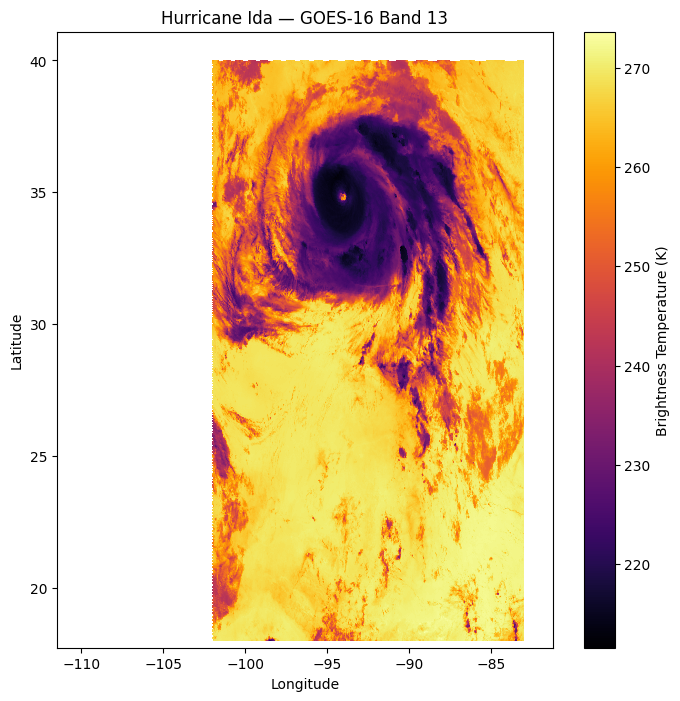

In [25]:
ds = get_goes_dataset(
    year=2021, month=8, day=29, hour=14,
    band="12", product="ABI-L2-CMIPF", sat="goes-east"
)


ds = add_lat_lon(ds)

ida = ds.CMI.isel(time=0)

ida_trim = trim_region(ida)

plot_hurricane(ida_trim, title="Hurricane Ida — GOES-16 Band 13")
#export_csv(ida_trim, "ida_trim.csv")

In [ ]:
timestamps = [
    (2021, 8, 28, 6),
    (2021, 8, 28, 9),
    (2021, 8, 28, 12),
    (2021, 8, 28, 15),
    (2021, 8, 28, 18),
    (2021, 8, 28, 21),

    (2021, 8, 29, 0),
    (2021, 8, 29, 3),
    (2021, 8, 29, 6),
    (2021, 8, 29, 9),
    (2021, 8, 29, 12),
    (2021, 8, 29, 15),
    (2021, 8, 29, 18),
    (2021, 8, 29, 21),

    (2021, 8, 30, 0),
    (2021, 8, 30, 3)
]

for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data)
    filename = f"ida_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")

In [5]:
import pandas as pd
import numpy as np
import json
import glob
import os
import datetime as dt
from pyproj import Proj

In [ ]:
import pandas as pd
import numpy as np
import os

IDA_FILES = [
  'raw_data/ida_20210828_06Z.csv', 'raw_data/ida_20210828_09Z.csv', 'raw_data/ida_20210828_12Z.csv', 
  'raw_data/ida_20210828_15Z.csv', 'raw_data/ida_20210828_18Z.csv', 'raw_data/ida_20210828_21Z.csv',
  'raw_data/ida_20210829_00Z.csv', 'raw_data/ida_20210829_03Z.csv', 'raw_data/ida_20210829_06Z.csv', 
  'raw_data/ida_20210829_09Z.csv', 'raw_data/ida_20210829_12Z.csv', 'raw_data/ida_20210829_15Z.csv', 
  'raw_data/ida_20210829_18Z.csv', 'raw_data/ida_20210829_21Z.csv', 'raw_data/ida_20210830_00Z.csv', 
  'raw_data/ida_20210830_03Z.csv'
]

In [15]:

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in IDA_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

Starting uniform sampling: keeping 1 out of every 3 points...
  -> Saved as ida_20210828_06Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210828_09Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210828_12Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210828_15Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210828_18Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210828_21Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210829_00Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210829_03Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210829_06Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210829_09Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210829_12Z_sampled.csv with 198,100 rows (original: 594,298).
  -> Saved as ida_20210829_15Z_sampl

Found 4 files for 2017-9-7 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()
C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\1718549950.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(


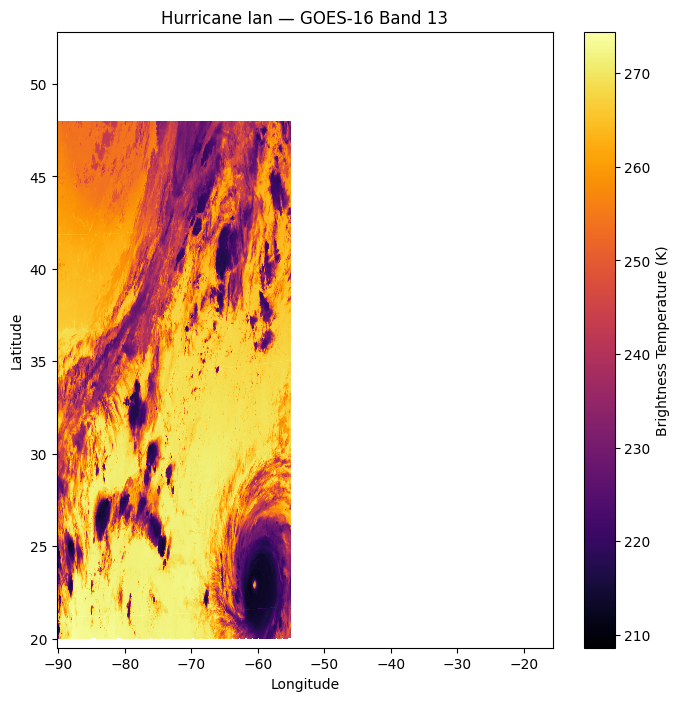

In [27]:
ds = get_goes_dataset(
    year=2017, month=9, day=6, hour=0,
    band="12", product="ABI-L2-CMIPF", sat="goes-east"
)

ds = add_lat_lon(ds)

irma = ds.CMI.isel(time=0)

irma_trim = trim_region(irma, 20, 48, -90, -55)

plot_hurricane(irma_trim, title="Hurricane Ian — GOES-16 Band 13")



In [7]:
import pandas as pd
import numpy as np
import os

In [10]:
timestamps = [
    (2022, 9, 26, 12),
    (2022, 9, 26, 18),

    (2022, 9, 27, 0),
    (2022, 9, 27, 6),
    (2022, 9, 27, 12),
    (2022, 9, 27, 18),

    (2022, 9, 28, 0),
    (2022, 9, 28, 3),
    (2022, 9, 28, 6),
    (2022, 9, 28, 9),
    (2022, 9, 28, 12),
    (2022, 9, 28, 15),
    (2022, 9, 28, 18),
    (2022, 9, 28, 21),
    
    (2022, 9, 29, 0),
    (2022, 9, 29, 6),
]
for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data, 18, 40, -90, -71)
    filename = f"ian_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")


=== Processing Frame 1/16 — 2022-9-26 12Z ===
Found 6 files for 2022-9-26 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 1/16.

=== Processing Frame 2/16 — 2022-9-26 18Z ===
Found 6 files for 2022-9-26 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 2/16.

=== Processing Frame 3/16 — 2022-9-27 0Z ===
Found 6 files for 2022-9-27 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 3/16.

=== Processing Frame 4/16 — 2022-9-27 6Z ===
Found 6 files for 2022-9-27 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 4/16.

=== Processing Frame 5/16 — 2022-9-27 12Z ===
Found 6 files for 2022-9-27 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 5/16.

=== Processing Frame 6/16 — 2022-9-27 18Z ===
Found 6 files for 2022-9-27 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 6/16.

=== Processing Frame 7/16 — 2022-9-28 0Z ===
Found 6 files for 2022-9-28 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 7/16.

=== Processing Frame 8/16 — 2022-9-28 3Z ===
Found 6 files for 2022-9-28 3Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 8/16.

=== Processing Frame 9/16 — 2022-9-28 6Z ===
Found 6 files for 2022-9-28 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 9/16.

=== Processing Frame 10/16 — 2022-9-28 9Z ===
Found 6 files for 2022-9-28 9Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 10/16.

=== Processing Frame 11/16 — 2022-9-28 12Z ===
Found 6 files for 2022-9-28 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 11/16.

=== Processing Frame 12/16 — 2022-9-28 15Z ===
Found 6 files for 2022-9-28 15Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 12/16.

=== Processing Frame 13/16 — 2022-9-28 18Z ===
Found 6 files for 2022-9-28 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 13/16.

=== Processing Frame 14/16 — 2022-9-28 21Z ===
Found 6 files for 2022-9-28 21Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 14/16.

=== Processing Frame 15/16 — 2022-9-29 0Z ===
Found 6 files for 2022-9-29 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 15/16.

=== Processing Frame 16/16 — 2022-9-29 6Z ===
Found 6 files for 2022-9-29 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_26336\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 16/16.
All 16 frames processed and exported!


In [ ]:
timestamps = [
    (2017, 9, 26, 12),
    (2017, 9, 26, 18),

    (2017, 9, 27, 0),
    (2017, 9, 27, 6),
    (2017, 9, 27, 12),
    (2017, 9, 27, 18),

    (2017, 9, 28, 0),
    (2017, 9, 28, 3),
    (2017, 9, 28, 6),
    (2017, 9, 28, 9),
    (2017, 9, 28, 12),
    (2017, 9, 28, 15),
    (2017, 9, 28, 18),
    (2017, 9, 28, 21),
    
    (2017, 9, 29, 0),
    (2017, 9, 29, 6),
]
for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data, 18, 40, -90, -71)
    filename = f"irma_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")

In [14]:
timestamps = [
    (2017, 8, 19, 6),
    (2017, 8, 19, 9),
    (2017, 8, 19, 12),
    (2017, 8, 19, 15),
    (2017, 8, 19, 18),
    (2017, 8, 19, 21),

    (2017, 8, 29, 0),
    (2017, 8, 29, 3),
    (2017, 8, 29, 6),
    (2017, 8, 29, 9),
    (2017, 8, 29, 12),
    (2017, 8, 29, 15),
    (2017, 8, 29, 18),
    (2017, 8, 29, 21),

    (2017, 8, 30, 0),
    (2017, 8, 30, 3)
]
for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data, 18, 40, -107, -88)
    filename = f"harvey_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")


=== Processing Frame 1/16 — 2017-8-19 6Z ===
Found 4 files for 2017-8-19 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 1/16.

=== Processing Frame 2/16 — 2017-8-19 9Z ===
Found 4 files for 2017-8-19 9Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 2/16.

=== Processing Frame 3/16 — 2017-8-19 12Z ===
Found 2 files for 2017-8-19 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 3/16.

=== Processing Frame 4/16 — 2017-8-19 15Z ===
Found 4 files for 2017-8-19 15Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 4/16.

=== Processing Frame 5/16 — 2017-8-19 18Z ===
Found 4 files for 2017-8-19 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 5/16.

=== Processing Frame 6/16 — 2017-8-19 21Z ===
Found 12 files for 2017-8-19 21Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 6/16.

=== Processing Frame 7/16 — 2017-8-29 0Z ===
Found 4 files for 2017-8-29 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 7/16.

=== Processing Frame 8/16 — 2017-8-29 3Z ===
Found 4 files for 2017-8-29 3Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 8/16.

=== Processing Frame 9/16 — 2017-8-29 6Z ===
Found 4 files for 2017-8-29 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 9/16.

=== Processing Frame 10/16 — 2017-8-29 9Z ===
Found 4 files for 2017-8-29 9Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 10/16.

=== Processing Frame 11/16 — 2017-8-29 12Z ===
Found 4 files for 2017-8-29 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 11/16.

=== Processing Frame 12/16 — 2017-8-29 15Z ===
Found 4 files for 2017-8-29 15Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 12/16.

=== Processing Frame 13/16 — 2017-8-29 18Z ===
Found 4 files for 2017-8-29 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 13/16.

=== Processing Frame 14/16 — 2017-8-29 21Z ===
Found 4 files for 2017-8-29 21Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 14/16.

=== Processing Frame 15/16 — 2017-8-30 0Z ===
Found 4 files for 2017-8-30 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 15/16.

=== Processing Frame 16/16 — 2017-8-30 3Z ===
Found 4 files for 2017-8-30 3Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_8932\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 16/16.
All 16 frames processed and exported!


In [ ]:
HARVEY_FILES = [
  'raw_data/harvey_20170819_06Z.csv', 'raw_data/harvey_20170819_09Z.csv', 'raw_data/harvey_20170819_12Z.csv', 
  'raw_data/harvey_20170819_15Z.csv', 'raw_data/harvey_20170819_18Z.csv', 'raw_data/harvey_20170819_21Z.csv',
  'raw_data/harvey_20170829_00Z.csv', 'raw_data/harvey_20170829_03Z.csv', 'raw_data/harvey_20170829_06Z.csv', 
  'raw_data/harvey_20170829_09Z.csv', 'raw_data/harvey_20170829_12Z.csv', 'raw_data/harvey_20170829_15Z.csv', 
  'raw_data/harvey_20170829_18Z.csv', 'raw_data/harvey_20170829_21Z.csv', 'raw_data/harvey_20170830_00Z.csv', 
  'raw_data/harvey_20170830_03Z.csv'
]

In [16]:

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in HARVEY_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

Starting uniform sampling: keeping 1 out of every 3 points...
  -> Saved as raw_data/harvey_20170819_06Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170819_09Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170819_12Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170819_15Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170819_18Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170819_21Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170829_00Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170829_03Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170829_06Z_sampled.csv with 210,177 rows (original: 630,530).
  -> Saved as raw_data/harvey_20170829_09Z_sampled.csv with 210,177 rows (original: 630,530)

In [11]:
IAN_FILES = [
  'raw_data/ian_20220926_12Z.csv', 'raw_data/ian_20220926_18Z.csv', 'raw_data/ian_20220927_00Z.csv', 
  'raw_data/ian_20220927_06Z.csv', 'raw_data/ian_20220927_12Z.csv', 'raw_data/ian_20220927_18Z.csv',
  'raw_data/ian_20220928_00Z.csv', 'raw_data/ian_20220928_03Z.csv', 'raw_data/ian_20220928_06Z.csv', 
  'raw_data/ian_20220928_09Z.csv', 'raw_data/ian_20220928_12Z.csv', 'raw_data/ian_20220928_15Z.csv', 
  'raw_data/ian_20220928_18Z.csv', 'raw_data/ian_20220928_21Z.csv', 'raw_data/ian_20220929_00Z.csv', 
  'raw_data/ian_20220929_06Z.csv'
]

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in IAN_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

Starting uniform sampling: keeping 1 out of every 3 points...
  -> Saved as raw_data/ian_20220926_12Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220926_18Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220927_00Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220927_06Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220927_12Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220927_18Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220928_00Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220928_03Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220928_06Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_20220928_09Z_sampled.csv with 211,877 rows (original: 635,631).
  -> Saved as raw_data/ian_2